In [325]:
# import necessary modules
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import os
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import seaborn as sns

In [326]:
# listing files
print(os.listdir("C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/Data"))
# training data
train = pd.read_csv("C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/Data/application_train.csv")
print('training dataset shape:', train.shape)
#print(train.columns)
test = pd.read_csv("C:/Users/manas/Desktop/Springboard/Capstone ideas/Home credit default risk/Data/application_test.csv")
print('test dataset shape:', test.shape)

['application_test.csv', 'application_train.csv', 'bureau.csv', 'bureau_balance.csv', 'credit_card_balance.csv', 'HomeCredit_columns_description.csv', 'installments_payments.csv', 'POS_CASH_balance.csv', 'previous_application.csv', 'sample_submission.csv']
training dataset shape: (307511, 122)
test dataset shape: (48744, 121)


In [275]:
train.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,24700.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,35698.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,6750.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,29686.5,...,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,21865.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0


## Exploratory data analysis

In [220]:
target_val = train['TARGET'].value_counts()
print(target_val)
print('% repaid loan: {:05.2f}'.format(target_val[0]/(target_val[0] + target_val[1])*100)) 
print('% difficulty in loan repayment: {:04.2f}'.format(target_val[1]/(target_val[0] + target_val[1])*100))


0    282686
1     24825
Name: TARGET, dtype: int64
% repaid loan: 91.93
% difficulty in loan repayment: 8.07


Discussion: Among 307511 applicants, 282686 (92%) repaid the loan on time. 24825 (8%) had difficulties in repaying. 

In [205]:
## Missing values in appication_train
print('Total number of variables:', train.shape[1])
miss_val = train.isnull().sum() # number of missing value in each col
miss_val = miss_val.sort_values(ascending=False) # sorting from max to min
miss_list = list(miss_val)
ind = miss_list.index(0)
miss_var = miss_val[0:ind] # only variables with missing values
print('Out of', train.shape[1], ', number of variables with missing values:', ind)

percent_miss = miss_var/len(train) * 100 # percent missing value for each variable
percents =[10 , 30, 50]
for percent in percents:
    for i in range(len(percent_miss)):
        if percent_miss.sort_values()[i] > percent:
            print('Out of', ind, ', there are', ind-i, 'variables with more than', percent, '% missing values')
            break

Total number of variables: 122
Out of 122 , number of variables with missing values: 67
Out of 67 , there are 57 variables with more than 10 % missing values
Out of 67 , there are 50 variables with more than 30 % missing values
Out of 67 , there are 41 variables with more than 50 % missing values


Discussion
Among 122 variables 67 variables have missing values. 57 variables have more than 10% value missing, 50 variables have more than 30% values missing, and 41 variables have more than 50% values missing. So, a large number of variables missing values. How can we deal with those missing values??

In [206]:
# variable type, object type are categorical variables
print('Variable types are:\n', train.dtypes.value_counts()) # variable type: integer, float, categorical
obj = train.select_dtypes('object') # selcting only categorical variable
obj_uni = obj.apply(pd.Series.nunique, axis=0) # unique values in category
print('\nUnique values in categorical variables are:\n', obj_uni.sort_values())

Variable types are:
 float64    65
int64      41
object     16
dtype: int64

Unique values in categorical variables are:
 NAME_CONTRACT_TYPE             2
FLAG_OWN_CAR                   2
FLAG_OWN_REALTY                2
EMERGENCYSTATE_MODE            2
CODE_GENDER                    3
HOUSETYPE_MODE                 3
FONDKAPREMONT_MODE             4
NAME_EDUCATION_TYPE            5
NAME_FAMILY_STATUS             6
NAME_HOUSING_TYPE              6
NAME_TYPE_SUITE                7
WEEKDAY_APPR_PROCESS_START     7
WALLSMATERIAL_MODE             7
NAME_INCOME_TYPE               8
OCCUPATION_TYPE               18
ORGANIZATION_TYPE             58
dtype: int64


### Preparing data

Label encoding and One-hot encoding: 

A totla of 4 categorical variables have 2 unique values. For categorical variables with 2 unique categories, we will use label encoding, and with more than 2 unique categories, we will use one-hot encoding. The purpose is to keep both the values in one column when unique category is 2. Thus the number of column is same here

In [327]:
# # fitting and transforming with label encoder
le = LabelEncoder()
le_count = 0
for col in train:
    if train[col].dtype == 'object':
        if len(list(train[col].unique())) <= 2: # for unique category less/equal 2
            le.fit(train[col]) # fitting and transforming with label encoder
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            le_count += 1
print(le_count)

3


In [328]:
## One hot encoding for unique category >2
train = pd.get_dummies(train)
test = pd.get_dummies(test)
print(train.shape, test.shape)

(307511, 243) (48744, 239)


Through one hot coding we have 3 extra features in train data. We will get rid of them using align.

In [329]:
## geting rid of excess columns in train dataset
train_labels = train['TARGET']
train, test = train.align(test, join = 'inner', axis=1)
train['TARGET'] = train_labels
print(train.shape, test.shape)

(307511, 240) (48744, 239)


In [330]:
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,0,1,0,1,0,1
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,1,0,0,0,0,0,0,1,0,0
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,0,0
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,0,0,0,0
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,0,0,0,0


From HomeCredit_columns_description.csv it is apparent that DAYS_BIRTH, DAYS_EMPLOYED, DAYS_REGISTRATION, DAYS_ID_PUBLISH, DAYS_LAST_PHONE_CHANGE columns are populated with the number of days relative to the application, thus are negative. 

In [211]:
days_columns = pd.concat([train.DAYS_BIRTH, train.DAYS_EMPLOYED, train.DAYS_REGISTRATION,train.DAYS_ID_PUBLISH, train.DAYS_LAST_PHONE_CHANGE], axis=1)
(days_columns/-365).describe() # summary statistics in terms of years (not days)

,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE
count,307511.000000,307511.000000,307511.000000,307511.000000,307510.000000
mean,43.936973,-174.835742,13.660604,8.203294,2.637969
std,11.956133,387.056895,9.651743,4.135481,2.265229
min,20.517808,-1000.665753,-0.000000,-0.000000,-0.000000
25%,34.008219,0.791781,5.506849,4.712329,0.750685
50%,43.150685,3.323288,12.339726,8.915068,2.073973
75%,53.923288,7.561644,20.491781,11.778082,4.301370
max,69.120548,49.073973,67.594521,19.717808,11.758904


The average age of applicant ~ 44 years, youngest ~ 21 year, oldest ~ 69 year .. sounds about right
Employment history: minimum and mean value are -1000 years and -174 years.. not right
Registration, id publish time and last phone change looks about right. 

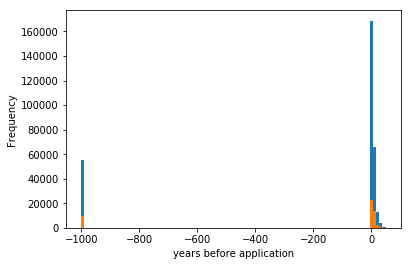

% anomaly in train: 18.01
% anomaly in test: 19.03


In [212]:
(train['DAYS_EMPLOYED']/-365).plot.hist(bins=100)
(test['DAYS_EMPLOYED']/-365).plot.hist(bins=100)
plt.xlabel('years before application')
plt.show()

print('% anomaly in train: {:05.2f}'.format(len(train[train['DAYS_EMPLOYED']== 365243]['DAYS_EMPLOYED'])
                                   /len(train['DAYS_EMPLOYED'])*100))
print('% anomaly in test: {:05.2f}'.format(len(test[test['DAYS_EMPLOYED']== 365243]['DAYS_EMPLOYED'])
                                   /len(test['DAYS_EMPLOYED'])*100))


A large spike can be seen at 1000 which are actually anomalies. There is anomali in 18% of total 'DAYS_EMPLOYED data

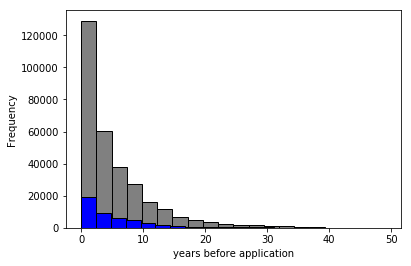

In [331]:
# creating an anamolous column in case it is useful
train['DAYS_EMPLOYED_ANOM'] = train['DAYS_EMPLOYED']==365243 # for training dataset
train['DAYS_EMPLOYED'].replace({365243:0}, inplace=True) # replacing anomaly with nan in train
test['DAYS_EMPLOYED_ANOM'] = test['DAYS_EMPLOYED']==365243 # for test dataset
test['DAYS_EMPLOYED'].replace({365243:0}, inplace=True) # replacing anomaly with nan in test


(train['DAYS_EMPLOYED']/-365).plot.hist(bins=20, color='gray', edgecolor = 'k')
(test['DAYS_EMPLOYED']/-365).plot.hist(bins=20, color='blue', edgecolor = 'k')
plt.xlabel('years before application')
plt.show()


In [332]:
train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,TARGET,DAYS_EMPLOYED_ANOM
0,100002,0,0,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0,0,0,1,0,1,0,1,False
1,100003,0,0,0,0,270000.0,1293502.5,35698.5,1129500.0,0.003541,...,0,0,0,0,0,0,1,0,0,False
2,100004,1,1,1,0,67500.0,135000.0,6750.0,135000.0,0.010032,...,0,0,0,0,0,0,0,0,0,False
3,100006,0,0,1,0,135000.0,312682.5,29686.5,297000.0,0.008019,...,0,0,0,0,0,0,0,0,0,False
4,100007,0,0,1,0,121500.0,513000.0,21865.5,513000.0,0.028663,...,0,0,0,0,0,0,0,0,0,False


## Correlation with TARGET

In [186]:
# find correlation of the features with target
correlations =  train.corr()['TARGET'].sort_values()


In [187]:
print('Most negative correlations:\n', correlations.head(10), '\n\nMost positive correlations\n', correlations.tail(10))

Most negative correlations:
 EXT_SOURCE_3                           -0.178919
EXT_SOURCE_2                           -0.160472
EXT_SOURCE_1                           -0.155317
NAME_EDUCATION_TYPE_Higher education   -0.056593
CODE_GENDER_F                          -0.054704
NAME_INCOME_TYPE_Pensioner             -0.046209
DAYS_EMPLOYED_ANOM                     -0.045987
ORGANIZATION_TYPE_XNA                  -0.045987
FLOORSMAX_AVG                          -0.044003
FLOORSMAX_MEDI                         -0.043768
Name: TARGET, dtype: float64 

Most positive correlations
 NAME_EDUCATION_TYPE_Secondary / secondary special    0.049824
REG_CITY_NOT_WORK_CITY                               0.050994
DAYS_ID_PUBLISH                                      0.051457
CODE_GENDER_M                                        0.054713
DAYS_LAST_PHONE_CHANGE                               0.055218
NAME_INCOME_TYPE_Working                             0.057481
REGION_RATING_CLIENT                              

The correlation of any individual variable with the target is not strong. DAYS_BIRTH has strongest positive relation and EXIT_SOURCE_3 has maximum negative correlation.

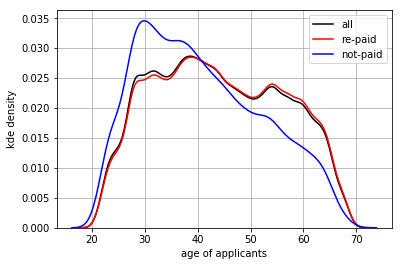

In [101]:
# Age vs. re-payment ability
sns.kdeplot(train['DAYS_BIRTH']/-365, label = 'all', color='black')
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_BIRTH'] / -365, label = 're-paid', color='red')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_BIRTH'] / -365, label = 'not-paid', color='blue')
plt.xlabel('age of applicants')
plt.ylabel('kde density')
plt.grid(True)
plt.show()

Applicants who re-paid the loan in time does not show much age dependence. But, who did not pay are mostly between 25 - 40 years  of age. 

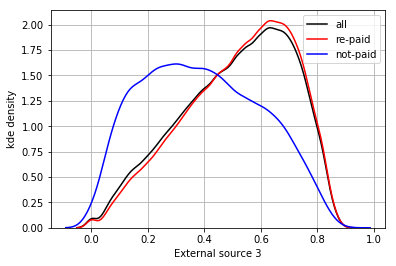

In [35]:
# external source vs. repayment ability
sns.kdeplot(train['EXT_SOURCE_3'], label = 'all', color='black')
sns.kdeplot(train.loc[train['TARGET'] == 0, 'EXT_SOURCE_3'], label = 're-paid', color='red')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'EXT_SOURCE_3'], label = 'not-paid', color='blue')
plt.xlabel('External source 3')
plt.ylabel('kde density')
plt.grid(True)
plt.show()


Applicants who repaid the loan have shown correlation withexternal source 3.

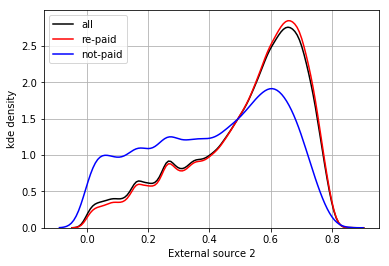

In [36]:
# external source vs. repayment ability
sns.kdeplot(train['EXT_SOURCE_2'], label = 'all', color='black')
sns.kdeplot(train.loc[train['TARGET'] == 0, 'EXT_SOURCE_2'], label = 're-paid', color='red')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'EXT_SOURCE_2'], label = 'not-paid', color='blue')
plt.xlabel('External source 2')
plt.ylabel('kde density')
plt.grid(True)
plt.show()


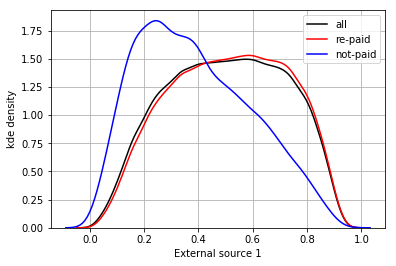

In [37]:
# external source vs. repayment ability
sns.kdeplot(train['EXT_SOURCE_1'], label = 'all', color='black')
sns.kdeplot(train.loc[train['TARGET'] == 0, 'EXT_SOURCE_1'], label = 're-paid', color='red')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'EXT_SOURCE_1'], label = 'not-paid', color='blue')
plt.xlabel('External source 1')
plt.ylabel('kde density')
plt.grid(True)
plt.show()


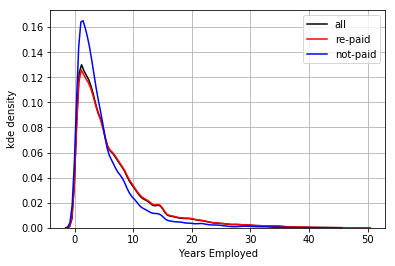

In [38]:
# employment period vs. repayment ability
sns.kdeplot(train['DAYS_EMPLOYED']/-365, label = 'all', color='black')
sns.kdeplot(train.loc[train['TARGET'] == 0, 'DAYS_EMPLOYED']/-365, label = 're-paid', color='red')
sns.kdeplot(train.loc[train['TARGET'] == 1, 'DAYS_EMPLOYED']/-365, label = 'not-paid', color='blue')
plt.xlabel('Years Employed')
plt.ylabel('kde density')
plt.grid(True)
plt.show()


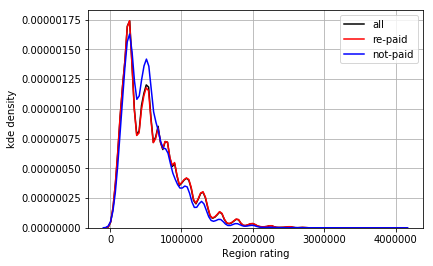

In [39]:
var = 'AMT_CREDIT'
sns.kdeplot(train[var], label = 'all', color='black')
sns.kdeplot(train.loc[train['TARGET'] == 0, var], label = 're-paid', color='red')
sns.kdeplot(train.loc[train['TARGET'] == 1, var], label = 'not-paid', color='blue')
plt.xlabel('Region rating')
plt.ylabel('kde density')
plt.grid(True)
plt.show()


First we will predict the model using only the features available at train and test dataset. There are many missing values. We first will replace them with median irrespective of the variable and then scale them with MinMaxScaler. 

Since EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3, and DAYS_BIRTH have stronger correlation with the TARGET, we will use them for creating new features

## Model prediction

First we will predict using ony the features at train and test dataset. Then we will include more features.

In [333]:
## substitute missing value with imputer then scaling with MinMaxScaler
from sklearn.preprocessing import MinMaxScaler, Imputer
train_target = train['TARGET']
train_id = train['SK_ID_CURR']
test_id = test['SK_ID_CURR']
train = train.drop(columns=['TARGET', 'SK_ID_CURR'])
test = test.drop(columns = ['SK_ID_CURR'])
features = list(train.columns)
test = test.copy()
imputer = Imputer(strategy='median')
scaler = MinMaxScaler(feature_range = (0, 1))
imputer.fit(train)
train = imputer.transform(train)
test = imputer.transform(test)
train

array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [334]:
train = pd.DataFrame(train, columns = features)
test = pd.DataFrame(test, columns = features)
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)
print(train.shape, test.shape)
train

(307511, 239) (48744, 239)


array([[0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 1., ..., 1., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [335]:
train = pd.DataFrame(train, columns = features)
test = pd.DataFrame(test, columns = features)
print(train.shape, test.shape)

(307511, 239) (48744, 239)


In [336]:
train.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Block,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM
0,0.0,0.0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.888839,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.477114,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1.0,1.0,1.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.348534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.350846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.298591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [337]:
train['SK_ID_CURR'] = train_id
test['SK_ID_CURR'] = test_id
#train['TARGET'] = train_target
print(train.shape, test.shape)
train.head()

(307511, 240) (48744, 240)


,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,SK_ID_CURR
0,0.0,0.0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.888839,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,100002
1,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.477114,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100003
2,1.0,1.0,1.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.348534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100004
3,0.0,0.0,1.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.350846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100006
4,0.0,0.0,1.0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.298591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100007


In [134]:
#train = train.drop(columns=['TARGET'])

Now the data is ready to be used for model prediction

In [338]:
# logistic regression
from sklearn.linear_model import LogisticRegression
log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(train, train_labels)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [339]:
test.shape

(48744, 240)

In [340]:
log_reg_pred = log_reg.predict_proba(test)[:, 1]
submit_lr = test[['SK_ID_CURR']]
submit_lr['TARGET'] = log_reg_pred
submit_lr.head()

,SK_ID_CURR,TARGET
0,100001,0.297015
1,100005,0.297008
2,100013,0.296993
3,100028,0.296966
4,100038,0.296948


Predicting the probability of not paying a loan. The predict_proba method returns a m x 2 array where m is the number of observations. The first column is the probability of repaying the loan and second is not repaying the loan. This is a straightforward method. No feature engineering is applied so far. The result is expected to be low. We will examine the scoe on 30% split data from train set.

In [341]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
X_train, X_valid, y_train, y_valid = train_test_split(train, train_labels, test_size = 0.3, random_state=42)
log_reg = LogisticRegression(C = 0.0001)
log_reg.fit(X_train, y_train)

LogisticRegression(C=0.0001, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

In [342]:
log_reg_valid = log_reg.predict_proba(X_valid)[:, 1]
valid_auc = roc_auc_score(y_valid, log_reg_valid)
valid_auc

0.5014474644361886

The auc is very low using logistic regression and without applying any feature engineering. Will it improve using random forest?

In [344]:
# prediction on test data
log_reg_pred = log_reg.predict_proba(test)[:, 1]

In [343]:
#train['TARGET'] = train_target
train.head()

,NAME_CONTRACT_TYPE,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,...,WALLSMATERIAL_MODE_Mixed,WALLSMATERIAL_MODE_Monolithic,WALLSMATERIAL_MODE_Others,WALLSMATERIAL_MODE_Panel,"WALLSMATERIAL_MODE_Stone, brick",WALLSMATERIAL_MODE_Wooden,EMERGENCYSTATE_MODE_No,EMERGENCYSTATE_MODE_Yes,DAYS_EMPLOYED_ANOM,SK_ID_CURR
0,0.0,0.0,1.0,0.0,0.001512,0.090287,0.090032,0.077441,0.256321,0.888839,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,100002
1,0.0,0.0,0.0,0.0,0.002089,0.311736,0.132924,0.271605,0.045016,0.477114,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,100003
2,1.0,1.0,1.0,0.0,0.000358,0.022472,0.020025,0.023569,0.134897,0.348534,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100004
3,0.0,0.0,1.0,0.0,0.000935,0.066837,0.109477,0.063973,0.107023,0.350846,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100006
4,0.0,0.0,1.0,0.0,0.000819,0.116854,0.078975,0.117845,0.392880,0.298591,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100007


In [345]:
# random forest
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
X_train, X_valid, y_train, y_valid = train_test_split(train, train_labels, test_size = 0.3, random_state=42)
rf = RandomForestClassifier(n_estimators = 100, random_state = 50, verbose = 1, n_jobs = -1)
rf.fit(X_train, y_train)

#random_forest.feature_importances_
predictions = rf.predict_proba(test)[:, 1]

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   21.9s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:   50.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished


In [346]:
rf_valid = rf.predict_proba(X_valid)[:, 1]
valid_auc = roc_auc_score(y_valid, rf_valid)
valid_auc

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.7s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.8s finished


0.7067298102781142

Using the score has improved from 0.5 to 0.7. That is a huge improvement. We can clearly conclude that random forest classifier is a better model than logistic regression for this dataset. What about LightGBM?

In [347]:
submit_rf = test[['SK_ID_CURR']]
submit_rf['TARGET'] = predictions
submit_rf.head()

,SK_ID_CURR,TARGET
0,100001,0.11
1,100005,0.13
2,100013,0.08
3,100028,0.09
4,100038,0.12


In [296]:
feature_importance_values = random_forest.feature_importances_
feature_importances = pd.DataFrame({'feature': train.columns, 'importance': feature_importance_values})
feature_importances = feature_importances.sort_values('importance', ascending=False).reset_index()
feature_importances.head()

,index,feature,importance
0,31,EXT_SOURCE_2,0.050311
1,32,EXT_SOURCE_3,0.046599
2,9,DAYS_BIRTH,0.032590
3,12,DAYS_ID_PUBLISH,0.031902
4,11,DAYS_REGISTRATION,0.031427


We will now use Light Gradient Boosting Machine

In [348]:
test.shape

(48744, 240)

In [313]:
# ## LightGBM
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
import lightgbm as lgb
import gc

def model(features, train_labels, test_features, n_folds = 5):
    
       
    # Extract the ids
    train_id = features['SK_ID_CURR']
    test_id = test_features['SK_ID_CURR']
    
    # Extract the labels for training
    labels = train_labels
    
    # Remove the ids and target
    features = features.drop(columns = ['SK_ID_CURR'])
    test_features = test_features.drop(columns = ['SK_ID_CURR'])
    
        
    print('Training Data Shape: ', features.shape)
    print('Testing Data Shape: ', test_features.shape)
    
    # Extract feature names
    feature_names = list(features.columns)
    
    # Convert to np arrays
    features = np.array(features)
    test_features = np.array(test_features)
    
    # Create the kfold object
    k_fold = KFold(n_splits = n_folds, shuffle = True, random_state = 50)
    
    # Empty array for feature importances
    feature_importance_values = np.zeros(len(feature_names))
    
    # Empty array for test predictions
    test_predictions = np.zeros(test_features.shape[0])
    
    # Empty array for out of fold validation predictions
    out_of_fold = np.zeros(features.shape[0])
    
    # Lists for recording validation and training scores
    valid_scores = []
    train_scores = []
    
    # Iterate through each fold
    for train_indices, valid_indices in k_fold.split(features):
        
        # Training data for the fold
        train_features, train_labels = features[train_indices], labels[train_indices]
        # Validation data for the fold
        valid_features, valid_labels = features[valid_indices], labels[valid_indices]
        
        # Create the model
        model = lgb.LGBMClassifier(n_estimators=10000, objective = 'binary', 
                                   class_weight = 'balanced', learning_rate = 0.05, 
                                   reg_alpha = 0.1, reg_lambda = 0.1, 
                                   subsample = 0.8, n_jobs = -1, random_state = 50)
        
        # Train the model
        model.fit(train_features, train_labels, eval_metric = 'auc',
                  eval_set = [(valid_features, valid_labels), (train_features, train_labels)],
                  eval_names = ['valid', 'train'],
                  early_stopping_rounds = 100, verbose = 200)
        
        # Record the best iteration
        best_iteration = model.best_iteration_
        
        # Record the feature importances
        feature_importance_values += model.feature_importances_ / k_fold.n_splits
        
        # Make predictions
        test_predictions += model.predict_proba(test_features, num_iteration = best_iteration)[:, 1] / k_fold.n_splits
        
        # Record the out of fold predictions
        out_of_fold[valid_indices] = model.predict_proba(valid_features, num_iteration = best_iteration)[:, 1]
        
        # Record the best score
        valid_score = model.best_score_['valid']['auc']
        train_score = model.best_score_['train']['auc']
        
        valid_scores.append(valid_score)
        train_scores.append(train_score)
        
        # Clean up memory
        gc.enable()
        del model, train_features, valid_features
        gc.collect()
        
    # Make the submission dataframe
    submission = pd.DataFrame({'SK_ID_CURR': test_id, 'TARGET': test_predictions})
    
    # Make the feature importance dataframe
    feature_importances = pd.DataFrame({'feature': feature_names, 'importance': feature_importance_values})
    
    # Overall validation score
    valid_auc = roc_auc_score(labels, out_of_fold)
    
    # Add the overall scores to the metrics
    valid_scores.append(valid_auc)
    train_scores.append(np.mean(train_scores))
    
    # Needed for creating dataframe of validation scores
    fold_names = list(range(n_folds))
    fold_names.append('overall')
    
    # Dataframe of validation scores
    metrics = pd.DataFrame({'fold': fold_names,
                            'train': train_scores,
                            'valid': valid_scores}) 
    
    return submission, feature_importances, metrics

In [314]:
submission, fi, metrics = model(train, train_labels, test)
print(metrics)

Training Data Shape:  (307511, 239)
Testing Data Shape:  (48744, 239)
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.75419	valid's binary_logloss: 0.564291	train's auc: 0.79685	train's binary_logloss: 0.554604
Early stopping, best iteration is:
[236]	valid's auc: 0.754503	valid's binary_logloss: 0.560752	train's auc: 0.80268	train's binary_logloss: 0.549463
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.756967	valid's binary_logloss: 0.564916	train's auc: 0.796783	train's binary_logloss: 0.554746
[400]	valid's auc: 0.756486	valid's binary_logloss: 0.547952	train's auc: 0.825181	train's binary_logloss: 0.529494
Early stopping, best iteration is:
[315]	valid's auc: 0.757299	valid's binary_logloss: 0.554498	train's auc: 0.814147	train's binary_logloss: 0.539536
Training until validation scores don't improve for 100 rounds.
[200]	valid's auc: 0.762238	valid's binary_logloss: 0.56585	train's auc: 0.795094	train's bina

Using the LightGBM model the auc score has been improved to 0.75 from 0.7 using random forest. So we will be using this model following feature engineering and assess improvement in the score.

In [315]:
fi_sorted = fi.sort_values('importance', ascending=False).reset_index()
fi_sorted.head() 


,index,feature,importance
0,30,EXT_SOURCE_1,547.6
1,32,EXT_SOURCE_3,506.2
2,31,EXT_SOURCE_2,445.0
3,9,DAYS_BIRTH,430.4
4,5,AMT_CREDIT,412.2
